## Day 13. Task 03
## Мультиклассовая классификация. One-hot encoding. Случайный лес
### 0. Импорты

In [49]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

### 1. Препроцессинг
 
1. Прочитайте файл, расположенный в datasets/checker_submits.csv.

In [50]:
df = pd.read_csv('checker_submits.csv', parse_dates=['timestamp']); df

,uid,labname,numTrials,timestamp
0,user_4,project1,1,2020-04-17 05:19:02.744528
1,user_4,project1,2,2020-04-17 05:22:45.549397
2,user_4,project1,3,2020-04-17 05:34:24.422370
3,user_4,project1,4,2020-04-17 05:43:27.773992
4,user_4,project1,5,2020-04-17 05:46:32.275104
...,...,...,...,...
1681,user_19,laba06s,9,2020-05-21 20:01:48.959966
1682,user_1,laba06s,6,2020-05-21 20:18:54.487900
1683,user_1,laba06s,7,2020-05-21 20:19:06.872761
1684,user_1,laba06s,8,2020-05-21 20:22:41.877806


2. Создайте датафрейм df со столбцами: uid, labname, numTrials, hour, dayofweek, где hour и dayofweek (0 – пн, 6 – вс) получены из timestamp. Вы будете пробовать прогнозировать день недели, основываясь на том, какой пользователь в какое время сделал какой по счету коммит какой лабораторной работы.

In [51]:
df['hour'] = df.timestamp.dt.hour
df['dayofweek'] = df.timestamp.dt.dayofweek
df.drop(columns='timestamp', inplace=True)
df

,uid,labname,numTrials,hour,dayofweek
0,user_4,project1,1,5,4
1,user_4,project1,2,5,4
2,user_4,project1,3,5,4
3,user_4,project1,4,5,4
4,user_4,project1,5,5,4
...,...,...,...,...,...
1681,user_19,laba06s,9,20,3
1682,user_1,laba06s,6,20,3
1683,user_1,laba06s,7,20,3
1684,user_1,laba06s,8,20,3


3. Используя OneHotEncoder() трансформируйте ваши категориальные признаки, удалив при этом изначальные столбцы.

In [52]:
encoder = OneHotEncoder(sparse=False)
encoded = encoder.fit_transform(df[['uid', 'labname']]).astype(int)
encoded

array([[0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1],
       ...,
       [0, 1, 0, ..., 0, 1, 0],
       [0, 1, 0, ..., 0, 1, 0],
       [0, 1, 0, ..., 0, 1, 0]])

In [53]:
encoder.categories_

[array(['user_0', 'user_1', 'user_10', 'user_11', 'user_12', 'user_13',
        'user_14', 'user_15', 'user_16', 'user_17', 'user_18', 'user_19',
        'user_2', 'user_20', 'user_21', 'user_22', 'user_23', 'user_24',
        'user_25', 'user_26', 'user_27', 'user_28', 'user_29', 'user_3',
        'user_30', 'user_31', 'user_4', 'user_6', 'user_7', 'user_8'],
       dtype=object),
 array(['code_rvw', 'lab02', 'lab03', 'lab03s', 'lab05s', 'laba04',
        'laba04s', 'laba05', 'laba06', 'laba06s', 'project1'], dtype=object)]

In [54]:
new_columns = list(encoder.categories_[0]) + list(encoder.categories_[1])

In [55]:
encoded = pd.DataFrame(encoded, columns = new_columns)
encoded

,user_0,user_1,user_10,user_11,user_12,user_13,user_14,user_15,user_16,user_17,...,lab02,lab03,lab03s,lab05s,laba04,laba04s,laba05,laba06,laba06s,project1
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1681,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1682,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1683,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1684,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [56]:
df = pd.concat(
    [df.drop(columns=['uid', 'labname']),
    encoded],
    axis=1
)
df

,numTrials,hour,dayofweek,user_0,user_1,user_10,user_11,user_12,user_13,user_14,...,lab02,lab03,lab03s,lab05s,laba04,laba04s,laba05,laba06,laba06s,project1
0,1,5,4,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,2,5,4,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,3,5,4,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,4,5,4,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,5,5,4,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1681,9,20,3,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1682,6,20,3,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1683,7,20,3,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1684,8,20,3,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


4. Воспользуйтесь StandardScaler(), чтобы стандартизировать ваши численные признаки.

In [57]:
scaler = StandardScaler()
df[['numTrials', 'hour']] = scaler.fit_transform(df[['numTrials', 'hour']])
df

,numTrials,hour,dayofweek,user_0,user_1,user_10,user_11,user_12,user_13,user_14,...,lab02,lab03,lab03s,lab05s,laba04,laba04s,laba05,laba06,laba06s,project1
0,-0.788667,-2.562352,4,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,-0.756764,-2.562352,4,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,-0.724861,-2.562352,4,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,-0.692958,-2.562352,4,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,-0.661055,-2.562352,4,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1681,-0.533442,0.945382,3,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1682,-0.629151,0.945382,3,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1683,-0.597248,0.945382,3,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1684,-0.565345,0.945382,3,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [ ]:
df[labname_code_r]

5. Сохраните этот датафрейм в файл dayofweek.csv.

In [58]:
df.to_csv('dayofweek.csv', index=False)

6. Прежде чем пробовать обучать разные алгоритмы, посчитайте accuracy для наивного прогноза – такого, где все предсказания есть самый популярный класс.

In [59]:
most_popular = df.dayofweek.value_counts().index[0]
naive = np.full_like(df.dayofweek, most_popular)
naive

array([3, 3, 3, ..., 3, 3, 3], dtype=int64)

In [60]:
accuracy_score(df.dayofweek, naive)

0.23487544483985764

### 2. Алгоритмы

In [61]:
X = df.drop(columns='dayofweek')
y = df.dayofweek
X

,numTrials,hour,user_0,user_1,user_10,user_11,user_12,user_13,user_14,user_15,...,lab02,lab03,lab03s,lab05s,laba04,laba04s,laba05,laba06,laba06s,project1
0,-0.788667,-2.562352,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,-0.756764,-2.562352,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,-0.724861,-2.562352,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,-0.692958,-2.562352,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,-0.661055,-2.562352,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1681,-0.533442,0.945382,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1682,-0.629151,0.945382,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1683,-0.597248,0.945382,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1684,-0.565345,0.945382,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


#### a. Логрегрессия
 
1. Обучите логистическую регрессию. Для baseline-модели используйте random_state=21, fit_intercept=False, solver='liblinear'.

In [62]:
lr_fit = LogisticRegression(C=1,
                            fit_intercept=False,
                            random_state=21,
                            solver='liblinear',
                            max_iter=100,
                            multi_class='auto').fit(X,y)

2. Посчитайте accuracy.

In [63]:
lr_fit.score(X, y)

0.6215895610913404

3. Напишите функцию, которая нарисует график (barh) и выведет на нем n наиболее важных признаков, используя коэффициенты обученных моделей и названия признаков.

In [64]:
def feature_bars(model, n):
    coefs = pd.DataFrame(model.coef_, columns=model.feature_names_in_)\
        .abs()\
        .sum()\
        .sort_values(ascending=False)
    coefs[0:n].plot.barh()

4. Воспользуйтесь функцией и нарисуйте для baseline-модели топ-10 наиболее важных признаков (абсолютные значения коэффициентов).
5. Помните, что вы работаете с мультиклассовой классификацией, и coef_ вернет вам матрицу. Чтобы посчитать важность (importance) для конкретного признака вам нужно будет просуммировать отдельные коэффициенты для всех значений целевой переменной.

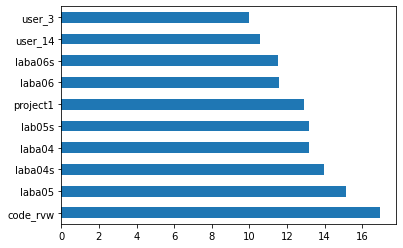

In [65]:
feature_bars(lr_fit, 10)

### b. SVC
 
1. Обучите модель SVC. Для baseline-модели воспользуйтесь параметрами kernel='linear', probability=True, random_state=21.

In [66]:
svc_fit = SVC(C=1,
            kernel='linear',
            degree=3,
            gamma='scale',
            coef0=0,
            shrinking=True,
            probability=True,
            random_state=21).fit(X, y)
svc_fit.score(X, y)

0.702846975088968

2. Попробуйте разные виды кернелов, посчитайте для них accuracy.

In [67]:
svc_fit_sigmoid = SVC(C=1,
            kernel='sigmoid',
            degree=3,
            gamma='scale',
            coef0=0,
            shrinking=True,
            probability=True,
            random_state=21).fit(X, y)
svc_fit_sigmoid.score(X, y)

0.3997627520759193

In [68]:
svc_fit_rbf = SVC(C=1,
            kernel='rbf',
            degree=3,
            gamma='scale',
            coef0=0,
            shrinking=True,
            probability=True,
            random_state=21).fit(X, y)
svc_fit_rbf.score(X, y)

0.8558718861209964

In [69]:
svc_fit_poly = SVC(C=1,
            kernel='poly',
            degree=3,
            gamma='scale',
            coef0=0,
            shrinking=True,
            probability=True,
            random_state=21).fit(X, y)
svc_fit_poly.score(X, y)

0.8594306049822064

3. Нарисуйте график (barh) с топ-10 наиболее важными признаками (абсолютное значение коэффициентов) для baseline-модели с линейным кернелом.

По умолчанию, SVC использует “one vs one” стратегию классификации. Это означает, что coef_ тоже вернет матрицу. Чтобы посчитать важность (importance) для конкретного признака вам нужно будет воспользоваться другой стратегией – OneVsRestClassifier и просуммировать отдельные коэффициенты для всех значений целевой переменной.

In [70]:
svc_fit_1 = SVC(C=1,
                kernel='linear',
                probability=True,
                random_state=21,
                decision_function_shape='ovr').fit(X, y)

In [71]:
pred_1 = svc_fit_1.predict(X)

In [72]:
svc_fit_2 = SVC(C=1,
                kernel='linear',
                probability=True,
                random_state=21,
                decision_function_shape='ovo').fit(X, y)

In [73]:
pred_2 = svc_fit_2.predict(X)

In [74]:
estimator = SVC(C=1,
                kernel='linear',
                probability=True,
                random_state=21)
svc_fit_3 = OneVsRestClassifier(estimator).fit(X, y)

In [75]:
pred_3 = svc_fit_3.predict(X)

In [76]:
np.array_equal(pred_1, pred_2)

True

In [77]:
np.array_equal(pred_1, pred_3)

False

In [78]:
np.allclose(svc_fit_1.coef_, svc_fit_2.coef_)

True

In [79]:
svc_fit_1.coef_.shape

(21, 43)

In [80]:
len(svc_fit_3.estimators_)

7

In [81]:
svc_fit_3.estimators_[0].coef_.shape

(1, 43)

In [82]:
sum = np.zeros_like(svc_fit_3.estimators_[0].coef_)
for est in svc_fit_3.estimators_:
    sum += abs(est.coef_)
sum

array([[0.73199241, 0.04593763, 1.04611895, 2.86817288, 4.42843791,
        4.87842647, 4.74843934, 4.56331664, 2.94959622, 2.82281563,
        2.81551866, 4.35407887, 2.80539862, 3.00803054, 6.00230142,
        2.99190148, 2.57797955, 4.29646348, 2.30110068, 4.36058518,
        3.22655729, 2.99240988, 2.81611162, 3.0989063 , 2.83866333,
        4.05440184, 2.84688388, 2.16318466, 3.87439089, 1.97990235,
        4.77484695, 2.96294383, 3.18170959, 1.04611895, 2.17650656,
        2.17556545, 3.90799618, 4.3681061 , 3.79099136, 5.22510153,
        5.14025802, 5.10185669, 4.9996905 ]])

In [83]:
coefs = pd.Series(sum[0], index=svc_fit_3.feature_names_in_)\
    .sort_values(ascending=False)
coefs

user_2       6.002301
laba05       5.225102
laba06       5.140258
laba06s      5.101857
project1     4.999690
user_11      4.878426
user_7       4.774847
user_12      4.748439
user_13      4.563317
user_10      4.428438
laba04       4.368106
user_24      4.360585
user_17      4.354079
user_22      4.296463
user_3       4.054402
lab05s       3.907996
user_4       3.874391
laba04s      3.790991
user_25      3.226557
code_rvw     3.181710
user_28      3.098906
user_19      3.008031
user_26      2.992410
user_20      2.991901
user_8       2.962944
user_14      2.949596
user_1       2.868173
user_30      2.846884
user_29      2.838663
user_15      2.822816
user_27      2.816112
user_16      2.815519
user_18      2.805399
user_21      2.577980
user_23      2.301101
lab03        2.176507
lab03s       2.175565
user_31      2.163185
user_6       1.979902
user_0       1.046119
lab02        1.046119
numTrials    0.731992
hour         0.045938
dtype: float64

<AxesSubplot:>

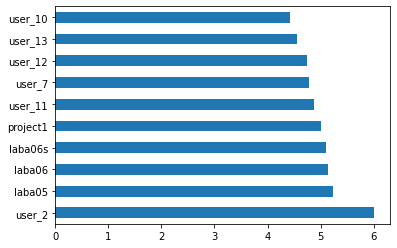

In [84]:
coefs[0:10].plot.barh()

### c. Дерево классификаций
 
1. Обучите DecisionTreeClassifier. Для baseline-модели воспользуйтесь следующими параметрами: max_depth=4, random_state=21.

In [85]:
tree_fit_4 = DecisionTreeClassifier(criterion='gini',
                                    max_depth=4,
                                    random_state=21
                                    ).fit(X, y)
tree_fit_4.score(X, y)

0.5516014234875445

2. Попробуйте разные значения max_depth. Посчитайте accuracy для этих вариантов.

In [86]:
tree_fit_10 = DecisionTreeClassifier(criterion='gini',
                                    max_depth=10,
                                    random_state=21
                                    ).fit(X, y)
tree_fit_10.score(X, y)

0.8196915776986952

In [87]:
tree_fit_None = DecisionTreeClassifier(criterion='gini',
                                    max_depth=None,
                                    random_state=21
                                    ).fit(X, y)
tree_fit_None.score(X, y)

1.0

3. Нарисуйте график (barh) с топ-10 наиболее важными признаками (абсолютное значение коэффициентов) для baseline-модели.

<AxesSubplot:>

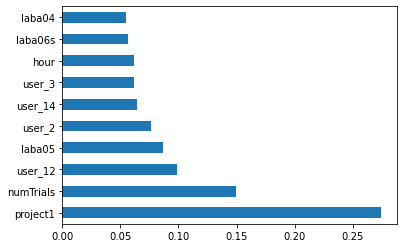

In [88]:
features = pd.Series(tree_fit_4.feature_importances_,
                    index=tree_fit_4.feature_names_in_)\
            .sort_values(ascending=False)
features[0:10].plot.barh()

### d. Случайный лес
 В реальной жизни леса состоят из деревьев. То же самое, как вы знаете, работает и в машинном обучении. Случайный лес – это множество отдельных деревьев классификации.
1. Обучите RandomForestClassifier. Для baseline-модели воспользуйтесь следующими параметрами: n_estimators=100, max_depth = 25, random_state=21.

In [89]:
forest = RandomForestClassifier(n_estimators=100,
                                max_depth=25,
                                random_state=21
                                ).fit(X, y)
forest.score(X, y)

1.0

In [90]:
for max_depth in [5, 10, 25, 100]:
    for n_estimators in [10, 50, 100]:
        forest = RandomForestClassifier(random_state=21,
                                        max_depth=max_depth,
                                        n_estimators=n_estimators).fit(X, y)
        print('Max depth: {} N estimators: {}, accuracy: {}'.format(max_depth,
                                                                    n_estimators,
                                                                    forest.score(X, y)))

Max depth: 5 N estimators: 10, accuracy: 0.603202846975089
Max depth: 5 N estimators: 50, accuracy: 0.5848161328588375
Max depth: 5 N estimators: 100, accuracy: 0.5794780545670225
Max depth: 10 N estimators: 10, accuracy: 0.8285883748517201
Max depth: 10 N estimators: 50, accuracy: 0.8701067615658363
Max depth: 10 N estimators: 100, accuracy: 0.8855278766310795
Max depth: 25 N estimators: 10, accuracy: 0.9958481613285883
Max depth: 25 N estimators: 50, accuracy: 1.0
Max depth: 25 N estimators: 100, accuracy: 1.0
Max depth: 100 N estimators: 10, accuracy: 0.9976275207591934
Max depth: 100 N estimators: 50, accuracy: 1.0
Max depth: 100 N estimators: 100, accuracy: 1.0


3. Нарисуйте график (barh) с топ-10 наиболее важными признаками (абсолютное значение коэффициентов) для baseline-модели.

<AxesSubplot:>

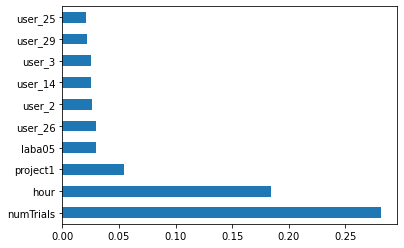

In [91]:
features = pd.Series(forest.feature_importances_,
                    index=forest.feature_names_in_)\
            .sort_values(ascending=False)
features[0:10].plot.barh()